# Race Detection

## Data Loading

In [1]:
import pandas as pd

In [2]:
Data_dir = "croped-images-2"
split = 0.7
w_img = h_img = 198
Gender = {0: 'male', 1: 'female'}
Gender_map = dict((g, i) for i, g in Gender.items())
Race = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
Race_map = dict((r, i) for i, r in Race.items())

Gender, Gender_map, Race, Race_map

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), Gender[int(gender)], Race[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [4]:
import glob
import os

In [5]:
files = glob.glob(os.path.join(Data_dir, "*.jpg"))

In [6]:
# from PIL import Image
# 
# def is_grey_scale(img_path):
#     img = Image.open(img_path).convert('RGB')
#     w, h = img.size
#     for i in range(w):
#         for j in range(h):
#             r, g, b = img.getpixel((i,j))
#             if r != g != b: 
#                 return False
#     return True

In [7]:
# for i in files:
# #     x = is_grey_scale(i)
#     im = Image.open(i)
#     im = im.resize((w_img, h_img))
#     im = np.array(im)/255
#     if len(im.shape)<3:
#         print(i, 'is')
#         im.resize((w_img, h_img, 3))
#         print(im.shape)
#     elif im.shape[2] != 3:
#         print(i, 'is', im.shape[2])
#         im.resize((w_img, h_img, 3))
#         print(im.shape)

In [8]:
attributes = list(map(parse_filepath, files))

croped-images-2\39_1_20170116174525125.jpg
croped-images-2\53_0_20170116184028385.jpg
croped-images-2\53__0_20170116184028385.jpg
croped-images-2\61_1_20170109142408075.jpg
croped-images-2\61_3_20170109150557335.jpg
croped-images-2\61_3_3_20170109150557335.jpg


In [9]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df

,age,gender,race,file
0,100.0,male,white,croped-images-2\100_0_0_20170112215240346.jpg
1,100.0,female,white,croped-images-2\100_1_0_20170110183726390.jpg
2,100.0,female,white,croped-images-2\100_1_0_20170112213001988.jpg
3,100.0,female,white,croped-images-2\100_1_0_20170112213303693.jpg
4,100.0,female,white,croped-images-2\100_1_0_20170112215032192.jpg
...,...,...,...,...
21971,9.0,female,indian,croped-images-2\9_1_3_20161220222856346.jpg
21972,9.0,female,indian,croped-images-2\9_1_3_20170104222949455.jpg
21973,9.0,female,others,croped-images-2\9_1_4_20170103200637399.jpg
21974,9.0,female,others,croped-images-2\9_1_4_20170103200814791.jpg


In [10]:
df.describe()

,age
count,21970.000000
mean,33.341238
std,19.592634
min,1.000000
25%,23.000000
50%,30.000000
75%,45.000000
max,116.000000


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

## Data Exploration & Visualization

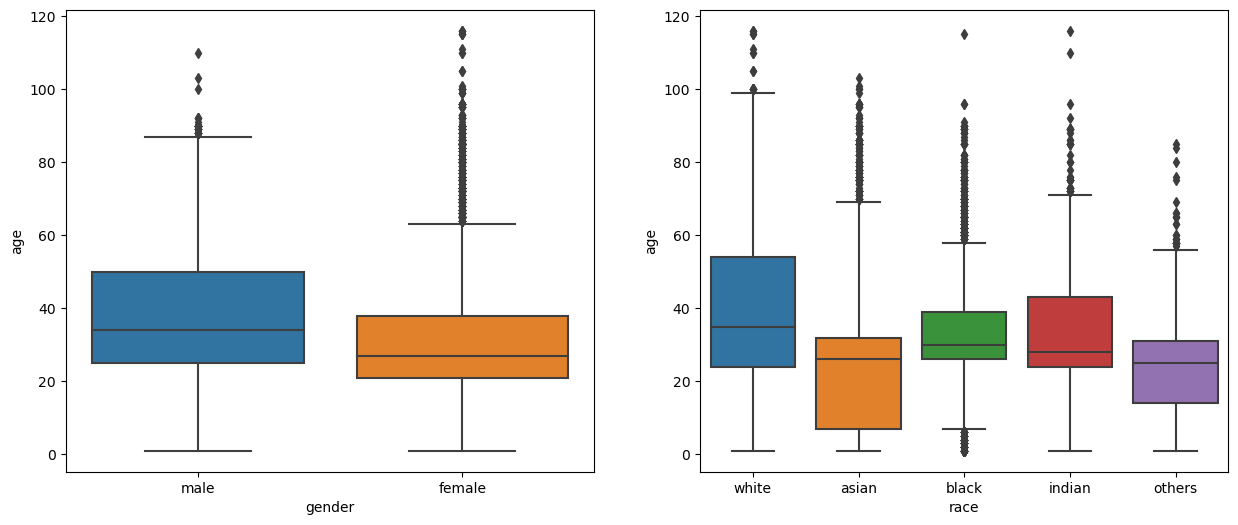

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<AxesSubplot:xlabel='gender', ylabel='age'>

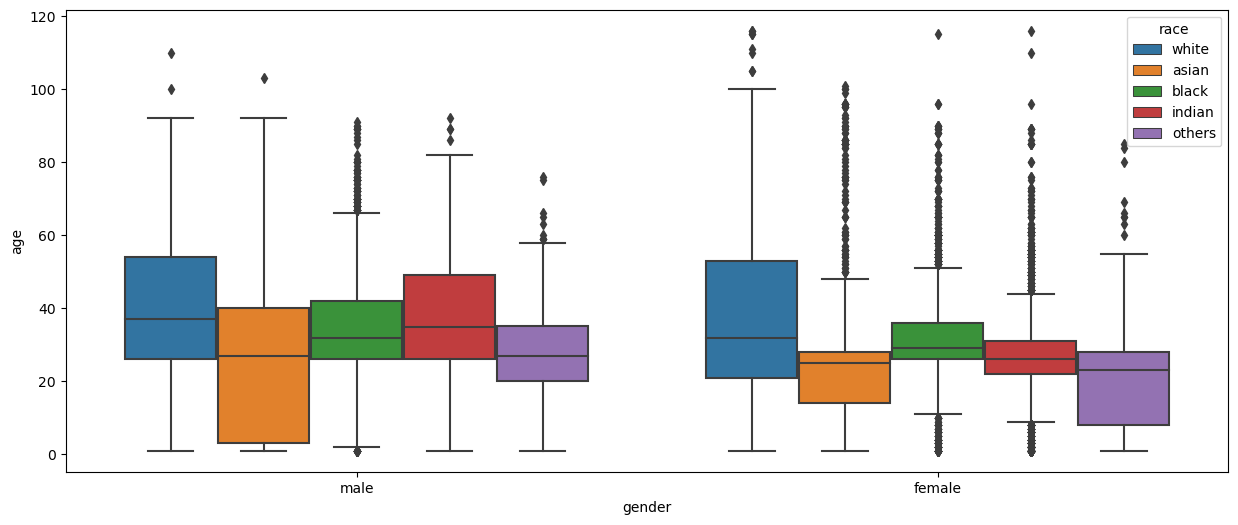

In [13]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<AxesSubplot:xlabel='race,gender'>

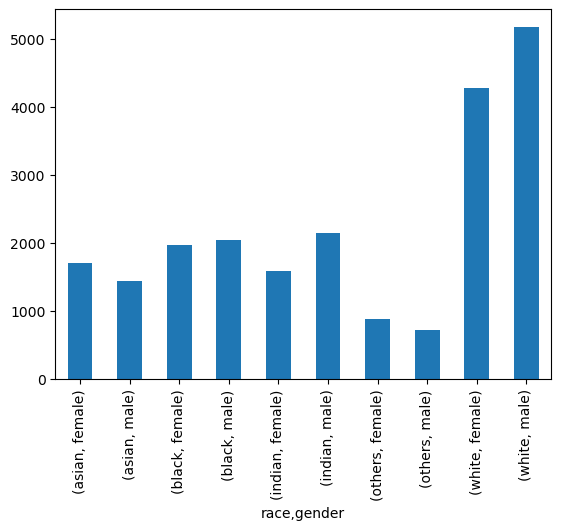

In [14]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<AxesSubplot:>

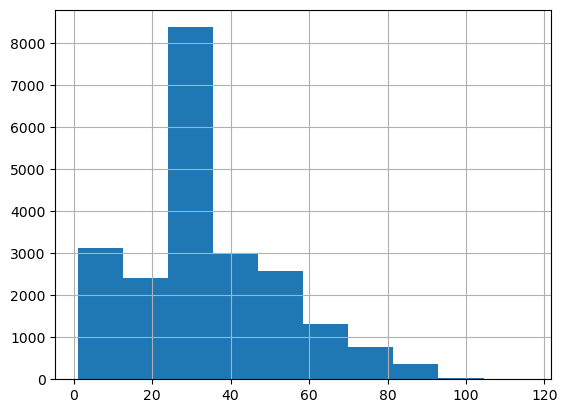

In [15]:
df['age'].hist()

In [16]:
df['age'].describe()

count    21970.000000
mean        33.341238
std         19.592634
min          1.000000
25%         23.000000
50%         30.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [17]:
# df = df[(df['age'] > 10) & (df['age'] < 65)]

## Data Preprocessing

In [18]:
import numpy as np

In [19]:
perm = np.random.permutation(len(df))
train_len = int(len(df) * split)
train = perm[:train_len]
test = perm[train_len:]

train_len = int(train_len * 0.7)
train, val = train[:train_len], train[train_len:]

df['gender_id'] = df['gender'].map(lambda gender: Gender_map[gender])
df['race_id'] = df['race'].map(lambda race: Race_map[race])

max_age = df['age'].max()

In [20]:
from keras.utils import to_categorical
from PIL import Image

In [21]:
def data_gen(df, indices, training, batch_sz):
    images = []
    races = []
    genders = []
    ages = []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            image = Image.open(file)
            image = image.resize((w_img, h_img))
            image = np.array(image)/255
#             if len(image.shape)<3:
#                 image.resize((w_img, h_img, 3))
#             elif image.shape[2] != 3:
#                 image.resize((w_img, h_img, 3))
# #             print(image.shape, file)
            images.append(image)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(Race_map)))
            genders.append(to_categorical(gender, 2))
            if len(images)>=batch_sz:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
#                 print(np.shape(images), np.shape(ages), np.shape(races), np.shape(genders))
                images = []
                races = []
                genders = []
                ages = []
        if not training:
            break

## Model

In [22]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import Adam
from keras.models import Model

In [23]:
print(len(Race_map), len(Gender_map))

5 2


In [24]:
input_1 = Input(shape=(h_img, w_img, 3))
conv_1 = Conv2D(filters=32, kernel_size=3, activation='relu')(input_1)
conv_1 = BatchNormalization()(conv_1)
conv_1 = MaxPool2D()(conv_1)

conv_2 = Conv2D(filters=64, kernel_size=3, activation='relu')(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = MaxPool2D()(conv_2)

conv_3 = Conv2D(filters=128, kernel_size=3, activation='relu')(conv_2)
conv_3 = BatchNormalization()(conv_3)
conv_3 = MaxPool2D()(conv_3)

conv_4 = Conv2D(filters=256, kernel_size=3, activation='relu')(conv_3)
conv_4 = BatchNormalization()(conv_4)
conv_4 = MaxPool2D()(conv_4)

conv_5 = Conv2D(filters=256, kernel_size=3, activation='relu')(conv_4)
conv_5 = BatchNormalization()(conv_5)
conv_5 = MaxPool2D()(conv_5)

gmax = GlobalMaxPool2D()(conv_5)

age = Dense(units=128, activation='relu')(gmax)
age = Dense(units=1, activation='sigmoid', name='age-output')(age)

race = Dense(units=128, activation='relu')(gmax)
race = Dense(units=len(Race_map), activation='softmax', name='race-output')(race)

gender = Dense(units=128, activation='relu')(gmax)
gender = Dense(units=len(Gender_map), activation='softmax', name='gender-output')(gender)

model = Model(inputs=input_1, outputs=[age, race, gender])
model.compile(optimizer='rmsprop',loss={'age-output': 'mse', 'race-output': 'categorical_crossentropy', 'gender-output': 'categorical_crossentropy'},
             loss_weights={'age-output': 2, 'race-output': 1.5, 'gender-output': 1},
             metrics={'age-output': 'mae', 'race-output': 'accuracy', 'gender-output': 'accuracy'})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 196, 196, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 196, 196, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [25]:
from keras.callbacks import ModelCheckpoint
# import tensorflow as tf
batch_size = 128
valid_batch_size = 128

# train = tf.convert_to_tensor(train, dtype=tf.int64) 
# val = tf.convert_to_tensor(val, dtype=tf.int64) 

train_gen = data_gen(df, train, training=True, batch_sz=batch_size)
valid_gen = data_gen(df, val, training=True, batch_sz=valid_batch_size)

In [26]:
# callbacks = [
#     ModelCheckpoint("./model_checkpoint", monitor='val_loss')
# ]

history = model.fit(train_gen,
                    steps_per_epoch=len(train)//batch_size,
                    epochs=100,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val)//valid_batch_size)

Epoch 1/100
84/84 [==============================] - 114s 1s/step - loss: 3.1021 - age-output_loss: 0.0593 - race-output_loss: 1.4394 - gender-output_loss: 0.8244 - age-output_mae: 0.1857 - race-output_accuracy: 0.4803 - gender-output_accuracy: 0.6297 - val_loss: 3.7743 - val_age-output_loss: 0.0325 - val_race-output_loss: 1.9933 - val_gender-output_loss: 0.7194 - val_age-output_mae: 0.1496 - val_race-output_accuracy: 0.4436 - val_gender-output_accuracy: 0.4833
Epoch 2/100
84/84 [==============================] - 40s 477ms/step - loss: 2.2387 - age-output_loss: 0.0314 - race-output_loss: 1.1023 - gender-output_loss: 0.5225 - age-output_mae: 0.1381 - race-output_accuracy: 0.5860 - gender-output_accuracy: 0.7390 - val_loss: 4.2456 - val_age-output_loss: 0.1012 - val_race-output_loss: 2.1836 - val_gender-output_loss: 0.7677 - val_age-output_mae: 0.2860 - val_race-output_accuracy: 0.4436 - val_gender-output_accuracy: 0.5050
Epoch 3/100
84/84 [==============================] - 40s 473ms/ste

84/84 [==============================] - 40s 479ms/step - loss: 0.2205 - age-output_loss: 0.0099 - race-output_loss: 0.0872 - gender-output_loss: 0.0699 - age-output_mae: 0.0730 - race-output_accuracy: 0.9703 - gender-output_accuracy: 0.9751 - val_loss: 3.1799 - val_age-output_loss: 0.0217 - val_race-output_loss: 1.7193 - val_gender-output_loss: 0.5576 - val_age-output_mae: 0.1151 - val_race-output_accuracy: 0.7051 - val_gender-output_accuracy: 0.8535
Epoch 19/100
84/84 [==============================] - 38s 452ms/step - loss: 0.2156 - age-output_loss: 0.0096 - race-output_loss: 0.0843 - gender-output_loss: 0.0699 - age-output_mae: 0.0726 - race-output_accuracy: 0.9732 - gender-output_accuracy: 0.9741 - val_loss: 3.2706 - val_age-output_loss: 0.0185 - val_race-output_loss: 1.7228 - val_gender-output_loss: 0.6494 - val_age-output_mae: 0.1044 - val_race-output_accuracy: 0.7174 - val_gender-output_accuracy: 0.8539
Epoch 20/100
84/84 [==============================] - 39s 465ms/step - loss

84/84 [==============================] - 38s 450ms/step - loss: 0.1167 - age-output_loss: 0.0073 - race-output_loss: 0.0483 - gender-output_loss: 0.0295 - age-output_mae: 0.0640 - race-output_accuracy: 0.9847 - gender-output_accuracy: 0.9893 - val_loss: 3.6240 - val_age-output_loss: 0.0131 - val_race-output_loss: 1.8438 - val_gender-output_loss: 0.8322 - val_age-output_mae: 0.0823 - val_race-output_accuracy: 0.7331 - val_gender-output_accuracy: 0.8516
Epoch 36/100
84/84 [==============================] - 37s 443ms/step - loss: 0.1102 - age-output_loss: 0.0073 - race-output_loss: 0.0448 - gender-output_loss: 0.0285 - age-output_mae: 0.0634 - race-output_accuracy: 0.9863 - gender-output_accuracy: 0.9896 - val_loss: 3.7033 - val_age-output_loss: 0.0128 - val_race-output_loss: 1.9469 - val_gender-output_loss: 0.7573 - val_age-output_mae: 0.0819 - val_race-output_accuracy: 0.7398 - val_gender-output_accuracy: 0.8483
Epoch 37/100
84/84 [==============================] - 38s 458ms/step - loss

84/84 [==============================] - 37s 447ms/step - loss: 0.0729 - age-output_loss: 0.0058 - race-output_loss: 0.0262 - gender-output_loss: 0.0220 - age-output_mae: 0.0572 - race-output_accuracy: 0.9919 - gender-output_accuracy: 0.9926 - val_loss: 4.5819 - val_age-output_loss: 0.0134 - val_race-output_loss: 2.3865 - val_gender-output_loss: 0.9753 - val_age-output_mae: 0.0825 - val_race-output_accuracy: 0.7177 - val_gender-output_accuracy: 0.8542
Epoch 53/100
84/84 [==============================] - 38s 452ms/step - loss: 0.0817 - age-output_loss: 0.0058 - race-output_loss: 0.0345 - gender-output_loss: 0.0185 - age-output_mae: 0.0566 - race-output_accuracy: 0.9898 - gender-output_accuracy: 0.9942 - val_loss: 5.2198 - val_age-output_loss: 0.0133 - val_race-output_loss: 2.4970 - val_gender-output_loss: 1.4479 - val_age-output_mae: 0.0830 - val_race-output_accuracy: 0.7402 - val_gender-output_accuracy: 0.8329
Epoch 54/100
84/84 [==============================] - 38s 452ms/step - loss

84/84 [==============================] - 38s 450ms/step - loss: 0.0651 - age-output_loss: 0.0051 - race-output_loss: 0.0275 - gender-output_loss: 0.0137 - age-output_mae: 0.0538 - race-output_accuracy: 0.9917 - gender-output_accuracy: 0.9953 - val_loss: 5.4003 - val_age-output_loss: 0.0235 - val_race-output_loss: 2.9320 - val_gender-output_loss: 0.9552 - val_age-output_mae: 0.1226 - val_race-output_accuracy: 0.6111 - val_gender-output_accuracy: 0.8201
Epoch 70/100
84/84 [==============================] - 38s 458ms/step - loss: 0.0764 - age-output_loss: 0.0050 - race-output_loss: 0.0322 - gender-output_loss: 0.0180 - age-output_mae: 0.0534 - race-output_accuracy: 0.9911 - gender-output_accuracy: 0.9930 - val_loss: 5.4245 - val_age-output_loss: 0.0152 - val_race-output_loss: 2.8356 - val_gender-output_loss: 1.1406 - val_age-output_mae: 0.0889 - val_race-output_accuracy: 0.7201 - val_gender-output_accuracy: 0.8542
Epoch 71/100
84/84 [==============================] - 37s 444ms/step - loss

84/84 [==============================] - 38s 455ms/step - loss: 0.0560 - age-output_loss: 0.0043 - race-output_loss: 0.0214 - gender-output_loss: 0.0152 - age-output_mae: 0.0499 - race-output_accuracy: 0.9937 - gender-output_accuracy: 0.9953 - val_loss: 5.9462 - val_age-output_loss: 0.0137 - val_race-output_loss: 3.0222 - val_gender-output_loss: 1.3854 - val_age-output_mae: 0.0854 - val_race-output_accuracy: 0.7415 - val_gender-output_accuracy: 0.8442
Epoch 87/100
84/84 [==============================] - 37s 442ms/step - loss: 0.0508 - age-output_loss: 0.0044 - race-output_loss: 0.0213 - gender-output_loss: 0.0100 - age-output_mae: 0.0502 - race-output_accuracy: 0.9940 - gender-output_accuracy: 0.9969 - val_loss: 5.6577 - val_age-output_loss: 0.0130 - val_race-output_loss: 2.8814 - val_gender-output_loss: 1.3097 - val_age-output_mae: 0.0818 - val_race-output_accuracy: 0.7159 - val_gender-output_accuracy: 0.8548
Epoch 88/100
84/84 [==============================] - 38s 455ms/step - loss

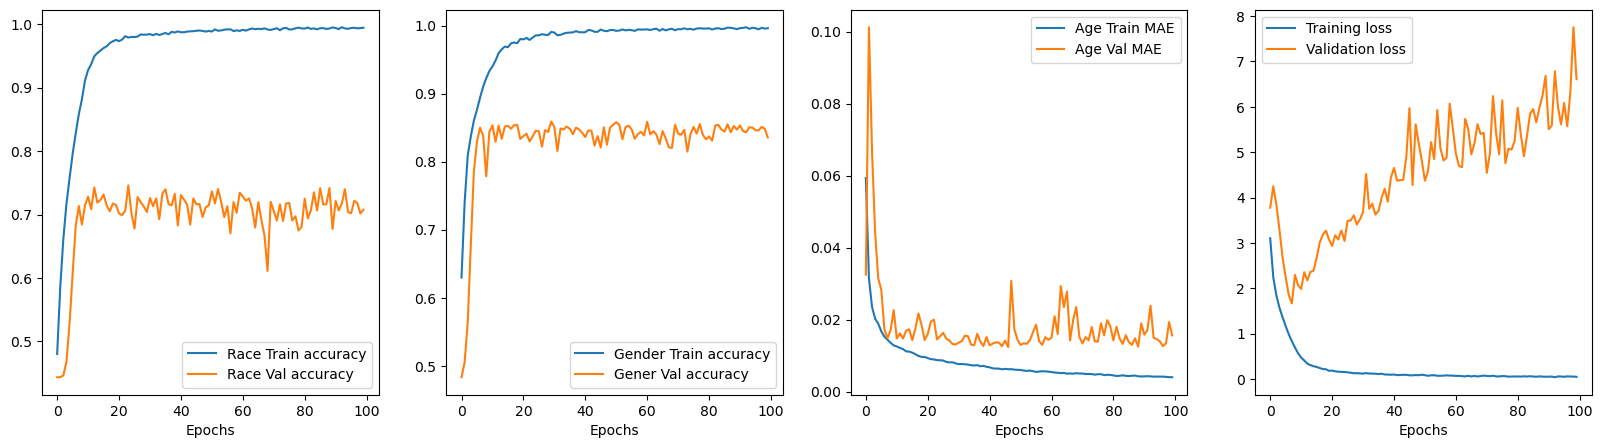

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].plot(history.history['race-output_accuracy'], label='Race Train accuracy')
axes[0].plot(history.history['val_race-output_accuracy'], label='Race Val accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend()

axes[1].plot(history.history['gender-output_accuracy'], label='Gender Train accuracy')
axes[1].plot(history.history['val_gender-output_accuracy'], label='Gener Val accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend()

axes[2].plot(history.history['age-output_loss'], label='Age Train MAE')
axes[2].plot(history.history['val_age-output_loss'], label='Age Val MAE')
axes[2].set_xlabel('Epochs')
axes[2].legend()  

axes[3].plot(history.history['loss'], label='Training loss')
axes[3].plot(history.history['val_loss'], label='Validation loss')
axes[3].set_xlabel('Epochs')
axes[3].legend()

In [28]:
test_gen = data_gen(df, test, training=False, batch_sz=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test)//128)))

51/51 [==============================] - 41s 815ms/step - loss: 6.0740 - age-output_loss: 0.0150 - race-output_loss: 3.0780 - gender-output_loss: 1.4269 - age-output_mae: 0.0909 - race-output_accuracy: 0.7161 - gender-output_accuracy: 0.8359


{'loss': 6.073965072631836,
 'age-output_loss': 0.015005906112492085,
 'race-output_loss': 3.0780396461486816,
 'gender-output_loss': 1.4268935918807983,
 'age-output_mae': 0.0908684954047203,
 'race-output_accuracy': 0.7161458134651184,
 'gender-output_accuracy': 0.8359375}

In [29]:
test_gen = data_gen(df, test, training=False, batch_sz=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [30]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [31]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.66      0.86      0.75        57
           1       0.86      0.55      0.67        22
           2       0.67      0.57      0.62        14
           3       0.56      0.41      0.47        22
           4       0.42      0.38      0.40        13

    accuracy                           0.65       128
   macro avg       0.63      0.55      0.58       128
weighted avg       0.65      0.65      0.64       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.77      0.89      0.82        71
           1       0.83      0.67      0.74        57

    accuracy                           0.79       128
   macro avg       0.80      0.78      0.78       128
weighted avg       0.79      0.79      0.79       128



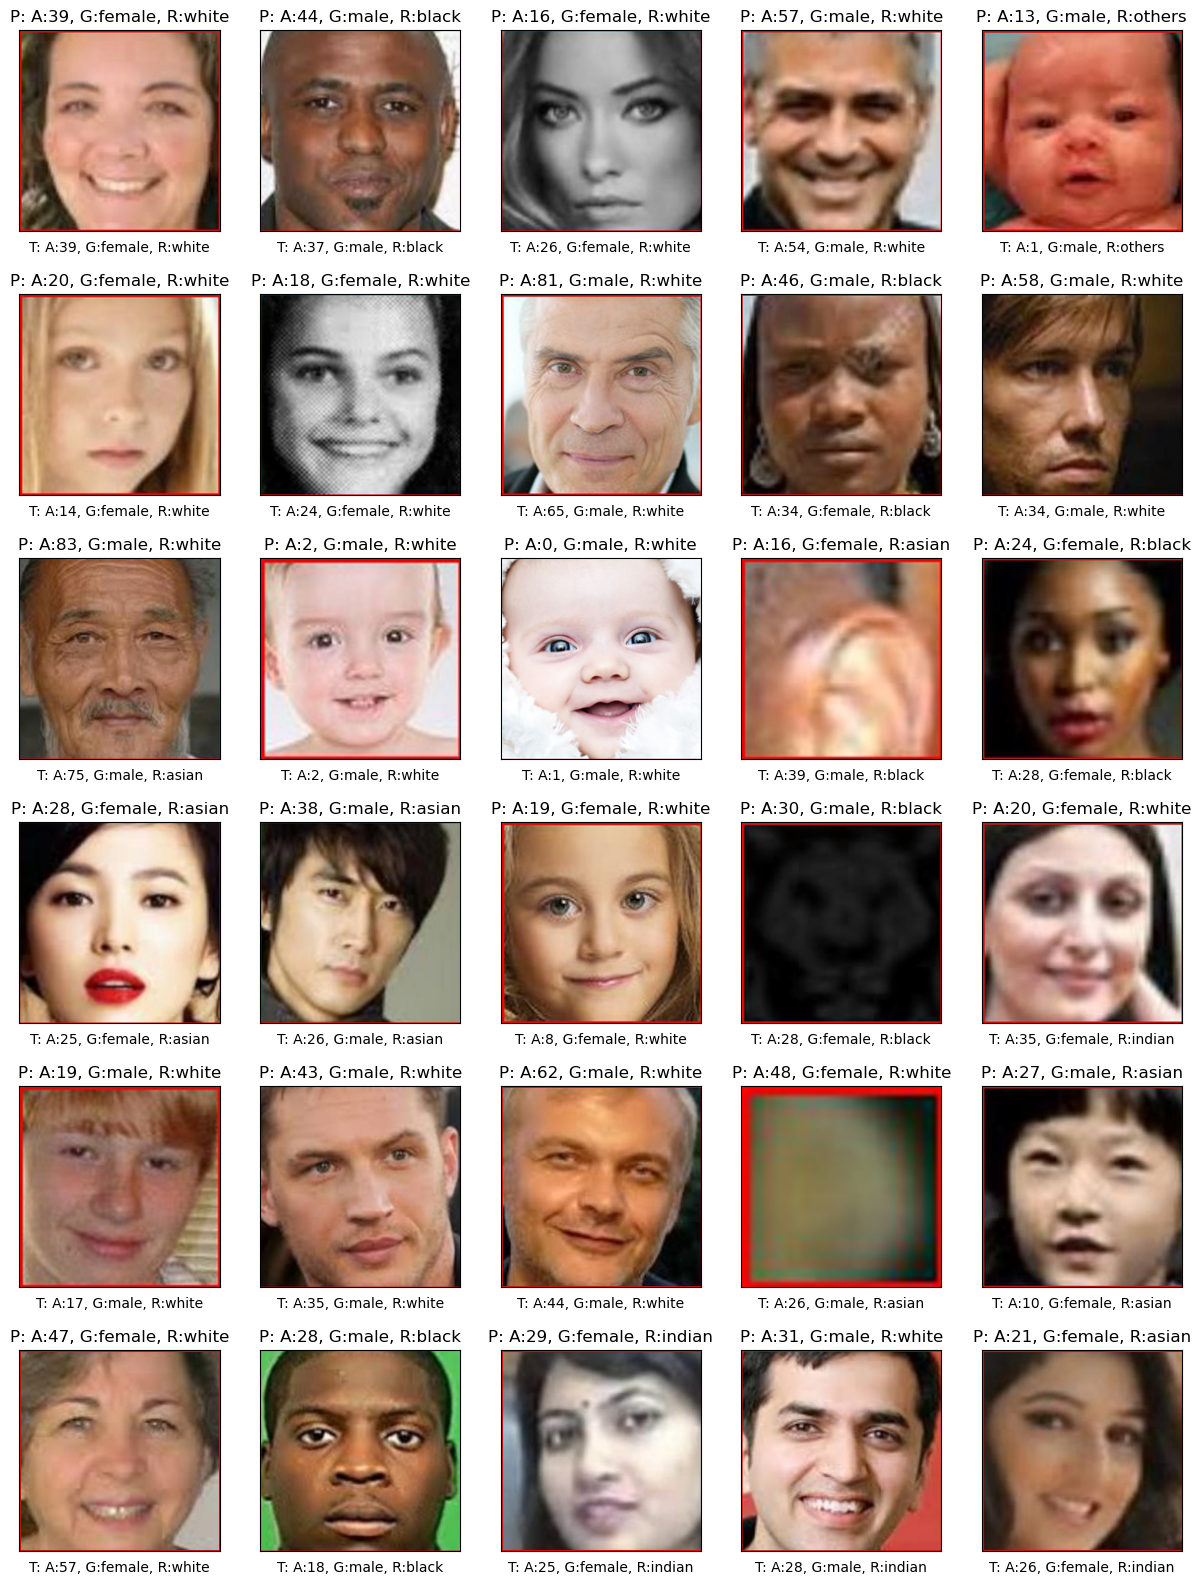

In [32]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('P: A:{}, G:{}, R:{}'.format(int(age_pred[img_idx]), Gender[gender_pred[img_idx]], Race[race_pred[img_idx]]))
    ax.set_xlabel('T: A:{}, G:{}, R:{}'.format(int(age_true[img_idx]), Gender[gender_true[img_idx]], Race[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])